In [1]:
# paquetes
import numpy as np
import gymnasium as gym
import mo_gymnasium as mo_gym
from collections import defaultdict
import matplotlib.pyplot as plt

In [3]:
# parámetros
env = mo_gym.make("mo-lunar-lander-v3")
num_act = env.action_space.n
alpha = 0.3
gamma = 0.999
eps = 25000  # número de episodios

# exploración
epsilon_i = 1.0  # inicial
epsilon_f = 0.01  # final
epsilon_d = 0.9999  # decay

In [4]:
# crea Q_set que guarda para cada estado 
_ = env.reset()
_, r_vec, _, _, _ = env.step(env.action_space.sample())
num_obj = len(r_vec)
Q = defaultdict(lambda: np.zeros((num_act, num_obj)))  

# diccs
front = []                   # frente de Pareto
r_hist = []                  # Recompensa por episodio
pareto_t_hist = []           # tamaño del frente de Pareto
t_traj = {}     # dicc de trayectorias que alcanzan el frente de Pareto

In [8]:
def discret(estado):
    return tuple(np.round(estado, decimals=1))

def selc_accion(estado, epsilon=0.1):
    q_valores = Q[estado]
    acc_nodom = [] # acciones no dominadas
    for a in range(num_act):
        dom = False
        for b in range(num_act):
            if a != b:
                if np.all(q_valores[b] >= q_valores[a]) and np.any(q_valores[b] > q_valores[a]):
                    dom = True
                    break
        if not dom:
            acc_nodom.append(a)
    if np.random.rand() < epsilon or len(acc_nodom) == 0:
        return np.random.randint(num_act)
    else:
        return np.random.choice(acc_nodom)

In [9]:
# actualizar frente de Pareto
def act(frontera, nuevo_vec):
    no_dominados = []
    for vec in frontera:
        if np.all(vec >= nuevo_vec) and np.any(vec > nuevo_vec):
            return frontera  
        elif not (np.all(nuevo_vec >= vec) and np.any(nuevo_vec > vec)):
            no_dominados.append(vec)
    no_dominados.append(nuevo_vec)
    return no_dominados

In [10]:
# Bucle de entrenamiento, ahora guardando también las trayectorias objetivo.
for ep in range(eps):
    epsilon_a = max(epsilon_f, epsilon_i * (epsilon_d ** ep))
    
    estado, _ = env.reset()
    estado = discret(estado)
    terminado = False
    r_acc = np.zeros(num_obj)  
    trajectory = []  # Lista para almacenar la secuencia del episodio
    
    while not terminado:
        accion = selc_accion(estado, epsilon=epsilon_a)
        nv_estado, r_vec, fin, tronco, _ = env.step(accion)
        nv_estado = discret(nv_estado)
        terminado = fin or tronco
        
        # Actualizar Q utilizando Q-learning
        mejor_sig = np.max(Q[nv_estado], axis=0)
        Q[estado][accion] = (1 - alpha) * Q[estado][accion] + alpha * (np.array(r_vec) + gamma * mejor_sig)
        
        # Guardamos la transición en la trayectoria del episodio
        trajectory.append((estado, accion, np.array(r_vec), nv_estado))
        
        estado = nv_estado
        r_acc += np.array(r_vec)
    
    r_hist.append(r_acc)
    front = act(front, r_acc)
    pareto_t_hist.append(len(front))
    
    # Check if the first objective is approximately 100 and positive.
    if np.isclose(r_acc[0], 100, atol=1e-3) and r_acc[0] > 0:
        t_traj[ep] = trajectory
        
    if ep % 100 == 0:
        print(f"Episodio {ep} (ε = {epsilon_a:.3f}), recompensa: {r_acc}")

env.close()

Episodio 0 (ε = 1.000), recompensa: [-100.           48.39544359  -22.          -41.        ]
Episodio 100 (ε = 0.990), recompensa: [-100.          -19.12660402  -24.          -59.        ]
Episodio 200 (ε = 0.980), recompensa: [-100.           67.17264467  -18.          -51.        ]
Episodio 300 (ε = 0.970), recompensa: [-100.          106.82048658  -17.          -39.        ]
Episodio 400 (ε = 0.961), recompensa: [-100.         -136.56451201  -25.          -49.        ]
Episodio 500 (ε = 0.951), recompensa: [-100.          -74.72932595  -17.          -37.        ]
Episodio 600 (ε = 0.942), recompensa: [-100.           96.41828399  -24.          -36.        ]
Episodio 700 (ε = 0.932), recompensa: [-100.         -211.67249306  -27.          -40.        ]
Episodio 800 (ε = 0.923), recompensa: [-100.          -94.86599262  -39.          -61.        ]
Episodio 900 (ε = 0.914), recompensa: [-100.           86.57023782  -24.          -48.        ]
Episodio 1000 (ε = 0.905), recompensa: [-1

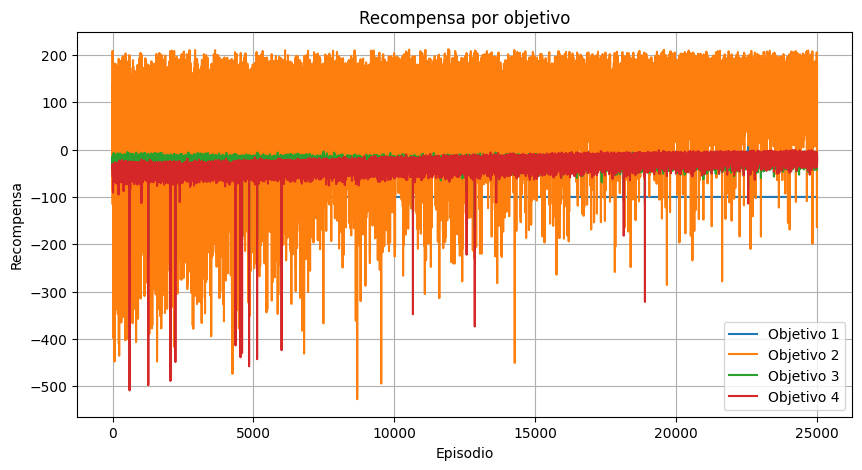

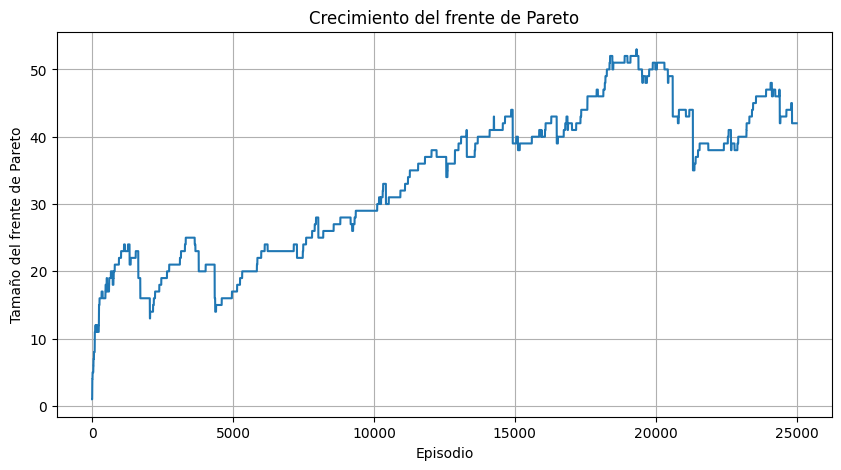

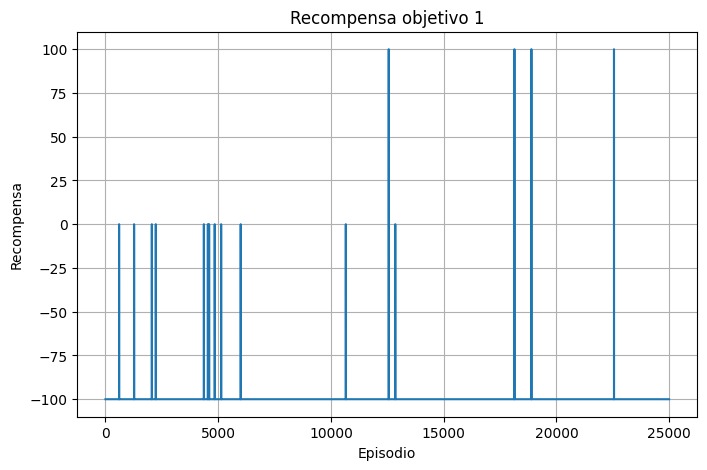

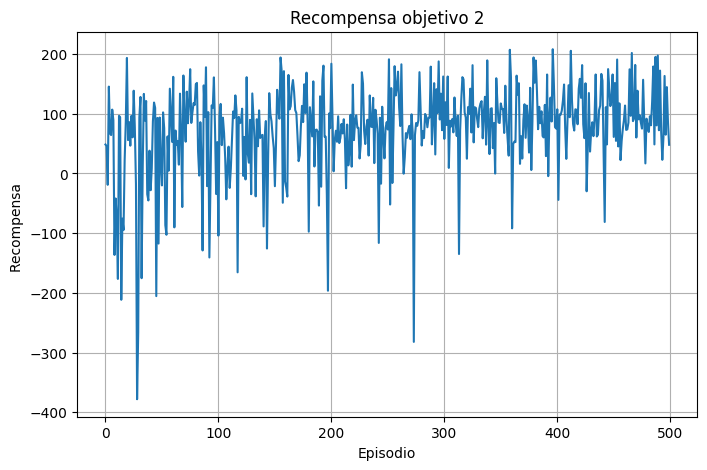

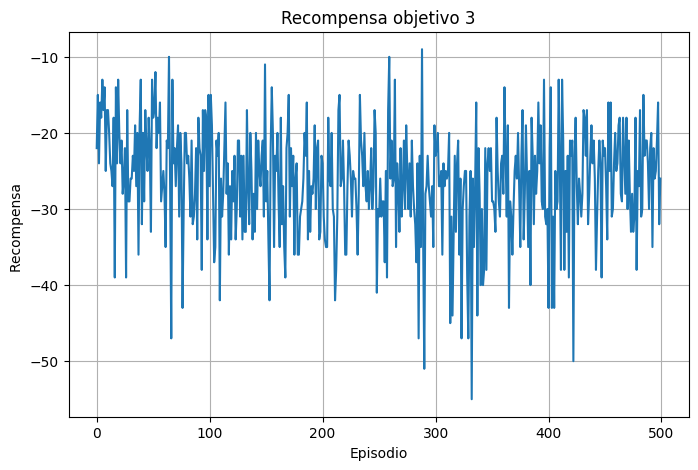

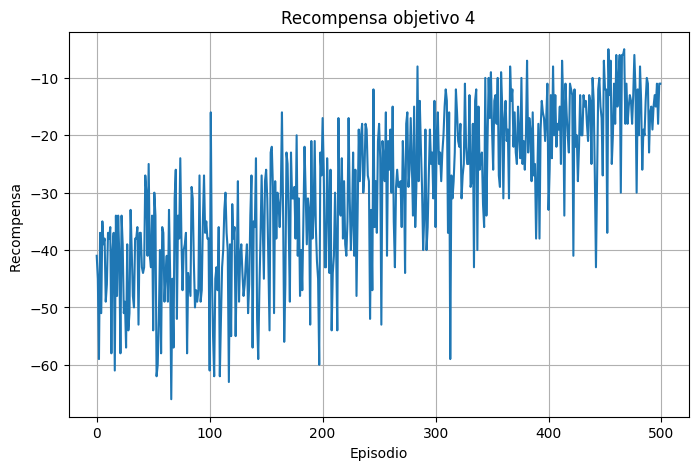

In [11]:
# graficas para ver que esta pasando
r_hist = np.array(r_hist)
plt.figure(figsize=(10, 5))
for i in range(num_obj):
    plt.plot(r_hist[:, i], label=f"Objetivo {i+1}")
plt.xlabel("Episodio")
plt.ylabel("Recompensa")
plt.title("Recompensa por objetivo")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(pareto_t_hist)
plt.xlabel("Episodio")
plt.ylabel("Tamaño del frente de Pareto")
plt.title("Crecimiento del frente de Pareto")
plt.grid(True)
plt.show()

# gráfica de la recompensa individual acumulada por objetivo a lo largo de los episodios
r_hist = np.array(r_hist)
for i in range(num_obj):
    if i == 0:
        plt.figure(figsize=(8, 5))
        plt.plot(r_hist[:, i])
        plt.xlabel("Episodio")
        plt.ylabel("Recompensa")
        plt.title(f"Recompensa objetivo {i+1}")
        plt.grid(True)
        plt.show()
    else:
        plt.figure(figsize=(8, 5))
        plt.plot(r_hist[:, i][::50])
        plt.xlabel("Episodio")
        plt.ylabel("Recompensa ")
        plt.title(f"Recompensa objetivo {i+1}")
        plt.grid(True)
        plt.show()

In [12]:
# trayectorias almacenadas
print("\ntrayectorias que cumplen que el primer obj es +100")
for ep, traj in t_traj.items():
    print(f"\nEpisodio {ep}:")
    for trans in traj:
        s, a, r, ns = trans
        print(f"Estado: {s} | Acción: {a} | Recompensa: {r} | Siguiente Estado: {ns}")



trayectorias que cumplen que el primer obj es +100

Episodio 12564:
Estado: (0.0, 1.4, 0.7, 0.4, -0.0, -0.2, 0.0, 0.0) | Acción: 2 | Recompensa: [ 0.        -3.4355597 -1.        -0.       ] | Siguiente Estado: (0.0, 1.4, 0.7, 0.4, -0.0, -0.2, 0.0, 0.0)
Estado: (0.0, 1.4, 0.7, 0.4, -0.0, -0.2, 0.0, 0.0) | Acción: 0 | Recompensa: [ 0.         -0.44141117 -0.         -0.        ] | Siguiente Estado: (0.0, 1.4, 0.7, 0.4, -0.0, -0.2, 0.0, 0.0)
Estado: (0.0, 1.4, 0.7, 0.4, -0.0, -0.2, 0.0, 0.0) | Acción: 0 | Recompensa: [ 0.        -0.4476868 -0.        -0.       ] | Siguiente Estado: (0.0, 1.4, 0.7, 0.4, -0.0, -0.2, 0.0, 0.0)
Estado: (0.0, 1.4, 0.7, 0.4, -0.0, -0.2, 0.0, 0.0) | Acción: 2 | Recompensa: [ 0.       -2.267918 -1.       -0.      ] | Siguiente Estado: (0.0, 1.5, 0.7, 0.4, -0.0, -0.2, 0.0, 0.0)
Estado: (0.0, 1.5, 0.7, 0.4, -0.0, -0.2, 0.0, 0.0) | Acción: 1 | Recompensa: [ 0.          0.40051723 -0.         -1.        ] | Siguiente Estado: (0.0, 1.5, 0.7, 0.4, -0.0, -0.1, 0.0, 0.

In [17]:
# para ver alguna de las trajectorias
if t_traj:
    best_episode = list(t_traj.keys())[3] # cambiar el [1] por 0,1,2,..
    best_traj = t_traj[best_episode]
    print(f"Trayectoria del episodio {best_episode} para la política.")

    # definir la política
    policy = {}
    for transition in best_traj:
        s, action, r, ns = transition  
        policy[s] = action

    
    print("\n (estado -> acción):")
    for s, a in policy.items():
        print(f"{s} -> {a}")
else:
    print("nel")


Trayectoria del episodio 22555 para la política.

 (estado -> acción):
(-0.0, 1.4, -0.8, 0.4, 0.0, 0.2, 0.0, 0.0) -> 3
(-0.0, 1.4, -0.8, 0.4, 0.0, 0.1, 0.0, 0.0) -> 3
(-0.0, 1.5, -0.8, 0.3, 0.0, 0.1, 0.0, 0.0) -> 3
(-0.1, 1.5, -0.8, 0.3, 0.0, 0.0, 0.0, 0.0) -> 3
(-0.1, 1.5, -0.7, 0.2, 0.0, -0.1, 0.0, 0.0) -> 0
(-0.1, 1.5, -0.7, 0.1, 0.0, -0.1, 0.0, 0.0) -> 0
(-0.1, 1.5, -0.7, 0.0, 0.0, -0.1, 0.0, 0.0) -> 0
(-0.2, 1.5, -0.7, -0.1, 0.0, -0.1, 0.0, 0.0) -> 0
(-0.2, 1.5, -0.7, -0.2, -0.0, -0.1, 0.0, 0.0) -> 0
(-0.2, 1.5, -0.7, -0.2, -0.0, -0.0, 0.0, 0.0) -> 0
(-0.2, 1.5, -0.7, -0.3, -0.0, -0.1, 0.0, 0.0) -> 0
(-0.2, 1.4, -0.7, -0.4, -0.0, -0.1, 0.0, 0.0) -> 2
(-0.2, 1.4, -0.8, -0.3, -0.0, -0.1, 0.0, 0.0) -> 2
(-0.3, 1.4, -0.7, -0.3, -0.0, -0.1, 0.0, 0.0) -> 0
(-0.3, 1.4, -0.7, -0.4, -0.0, -0.1, 0.0, 0.0) -> 2
(-0.3, 1.4, -0.7, -0.4, -0.1, -0.1, 0.0, 0.0) -> 2
(-0.3, 1.3, -0.7, -0.4, -0.1, -0.1, 0.0, 0.0) -> 0
(-0.4, 1.3, -0.7, -0.4, -0.1, -0.1, 0.0, 0.0) -> 0
(-0.4, 1.3, -0.7, -0.5, -0.1, 

In [19]:
from gymnasium.wrappers import RecordVideo

env_replay = mo_gym.make("mo-lunar-lander-v3", render_mode="human")

s, _ = env_replay.reset()
s = discret(s)
done = False

while not done:
    if s in policy:
        action = policy[s]
    else:
        action = selc_accion(s, epsilon=0)
        
    ns, r, done, trunco, info = env_replay.step(action)
    ns = discret(ns)

    print(f"Estado: {s} -> Acción: {action} -> Sig. estado: {ns}")
    
    s = ns
    if done or trunco:
        break

env_replay.close()

Estado: (-0.0, 1.4, -0.4, 0.4, 0.0, 0.1, 0.0, 0.0) -> Acción: 0 -> Sig. estado: (-0.0, 1.4, -0.4, 0.4, 0.0, 0.1, 0.0, 0.0)
Estado: (-0.0, 1.4, -0.4, 0.4, 0.0, 0.1, 0.0, 0.0) -> Acción: 0 -> Sig. estado: (-0.0, 1.4, -0.4, 0.3, 0.0, 0.1, 0.0, 0.0)
Estado: (-0.0, 1.4, -0.4, 0.3, 0.0, 0.1, 0.0, 0.0) -> Acción: 0 -> Sig. estado: (-0.0, 1.4, -0.4, 0.3, 0.0, 0.1, 0.0, 0.0)
Estado: (-0.0, 1.4, -0.4, 0.3, 0.0, 0.1, 0.0, 0.0) -> Acción: 0 -> Sig. estado: (-0.0, 1.4, -0.4, 0.3, 0.0, 0.1, 0.0, 0.0)
Estado: (-0.0, 1.4, -0.4, 0.3, 0.0, 0.1, 0.0, 0.0) -> Acción: 0 -> Sig. estado: (-0.0, 1.5, -0.4, 0.3, 0.0, 0.1, 0.0, 0.0)
Estado: (-0.0, 1.5, -0.4, 0.3, 0.0, 0.1, 0.0, 0.0) -> Acción: 0 -> Sig. estado: (-0.0, 1.5, -0.4, 0.2, 0.0, 0.1, 0.0, 0.0)
Estado: (-0.0, 1.5, -0.4, 0.2, 0.0, 0.1, 0.0, 0.0) -> Acción: 0 -> Sig. estado: (-0.0, 1.5, -0.4, 0.2, 0.0, 0.1, 0.0, 0.0)
Estado: (-0.0, 1.5, -0.4, 0.2, 0.0, 0.1, 0.0, 0.0) -> Acción: 3 -> Sig. estado: (-0.0, 1.5, -0.4, 0.2, 0.0, 0.1, 0.0, 0.0)
Estado: (-0.0, 1